**References:**

1. https://keras.io/api/applications/
2. https://keras.io/guides/transfer_learning/

In [56]:
!nvidia-smi

Mon Feb 15 15:27:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    60W / 149W |   4407MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

P100

In [57]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd '/content/gdrive/MyDrive/Journal_paper'
! ls

In [59]:
pip install tensorflow-addons

In [60]:
# import the basic libraries
import numpy as np
import tensorflow as tf 
import tensorflow_addons as tfa
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Flatten, Reshape, ReLU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import Concatenate, Lambda, add
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, regularizers, optimizers
from glob import glob

**Self-built architecture**

**1. Model 1**

In [62]:
# model
weight_decay = 1e-5

def TVT_1():
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, 3, padding = 'same', strides = 1, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay), input_shape=(224,224, 3)))
    model.add(BatchNormalization())
    model.add(tfa.layers.InstanceNormalization())
    model.add(Activation('relu')) 
    model.add(MaxPooling2D()) 

    # Block 2
    model.add(Conv2D(64, 3, padding = 'same', strides = 1, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
    model.add(BatchNormalization())
    model.add(tfa.layers.InstanceNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())  
     
    # FCLs
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))

    return model

model1 = TVT_1()
model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_32 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
instance_normalization_32 (I (None, 224, 224, 32)      64        
_________________________________________________________________
activation_32 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_33 (Batc (None, 112, 112, 64)     

In [63]:
train_path = '/content/gdrive/MyDrive/Journal_paper/Database/train'
valid_path = '/content/gdrive/MyDrive/Journal_paper/Database/valid'
test_path = '/content/gdrive/MyDrive/Journal_paper/Database/test'

In [64]:
# tell the model what cost and optimization method to use
model1.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [65]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [66]:
# training
batch_size = 32
epochs = 50
steps = len(training_set) // batch_size

boundaries = [steps*15, steps*30]
values = [0.0001, 0.00005, 0.00001]
schedules = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
opt_adam  = keras.optimizers.Adam(learning_rate=schedules)

In [67]:
# fit the model
tvt1 = model1.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/50
27/27 [==============================] - 16s 532ms/step - loss: 47.6629 - accuracy: 0.3174 - val_loss: 4.8710 - val_accuracy: 0.5444
Epoch 2/50
27/27 [==============================] - 14s 519ms/step - loss: 4.0328 - accuracy: 0.6770 - val_loss: 0.4337 - val_accuracy: 0.9333
Epoch 3/50
27/27 [==============================] - 14s 519ms/step - loss: 1.6268 - accuracy: 0.8165 - val_loss: 0.6549 - val_accuracy: 0.8722
Epoch 4/50
27/27 [==============================] - 14s 515ms/step - loss: 1.3837 - accuracy: 0.8386 - val_loss: 0.6814 - val_accuracy: 0.8722
Epoch 5/50
27/27 [==============================] - 14s 519ms/step - loss: 0.8489 - accuracy: 0.8852 - val_loss: 0.1476 - val_accuracy: 0.9889
Epoch 6/50
27/27 [==============================] - 14s 519ms/step - loss: 0.6015 - accuracy: 0.9018 - val_loss: 0.2418 - val_accuracy: 0.9722
Epoch 7/50
27/27 [==============================] - 14s 518ms/step - loss: 0.6775 - accuracy: 0.9044 - val_loss: 0.1387 - val_accuracy: 0.966

In [68]:
# testing
score = model1.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.0242
Test accuracy: 0.9944


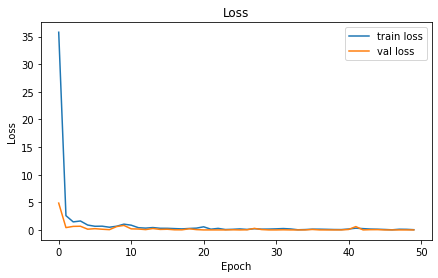

In [71]:
# loss
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
plt.plot(tvt1.history['loss'], label='train loss')
plt.plot(tvt1.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
fig.savefig('loss_model1')

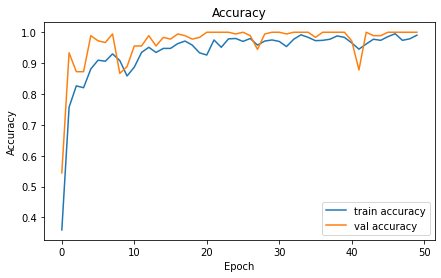

In [74]:
# accuracy
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
plt.plot(tvt1.history['accuracy'], label='train accuracy')
plt.plot(tvt1.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
fig.savefig('acc_model1')

**2. Model 2**

In [75]:
# model
weight_decay = 1e-5

def TVT_2():
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, 3, padding = 'same', strides = 1, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay), input_shape=(224,224, 3)))
    model.add(BatchNormalization())
    model.add(tfa.layers.InstanceNormalization())
    model.add(Activation('relu')) 
    model.add(Conv2D(32, 3, padding = 'same', strides = 1, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
    model.add(BatchNormalization())
    model.add(tfa.layers.InstanceNormalization())
    model.add(Activation('relu'))     
    model.add(MaxPooling2D()) 

    # Block 2
    model.add(Conv2D(64, 3, padding = 'same', strides = 1, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
    model.add(BatchNormalization())
    model.add(tfa.layers.InstanceNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, padding = 'same', strides = 1, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
    model.add(BatchNormalization())
    model.add(tfa.layers.InstanceNormalization())
    model.add(Activation('relu'))    
    model.add(MaxPooling2D())  
     
    # FCLs
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))

    return model

model2 = TVT_2()
model2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_34 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
instance_normalization_34 (I (None, 224, 224, 32)      64        
_________________________________________________________________
activation_34 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_35 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
instance_normalization_35 (I (None, 224, 224, 32)     

In [76]:
train_path = '/content/gdrive/MyDrive/Journal_paper/Database/train'
valid_path = '/content/gdrive/MyDrive/Journal_paper/Database/valid'
test_path = '/content/gdrive/MyDrive/Journal_paper/Database/test'

In [77]:
# tell the model what cost and optimization method to use
model2.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [78]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [79]:
# training
batch_size = 32
epochs = 50
steps = len(training_set) // batch_size

boundaries = [steps*15, steps*30]
values = [0.0001, 0.00005, 0.00001]
schedules = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
opt_adam  = keras.optimizers.Adam(learning_rate=schedules)

In [80]:
# fit the model
tvt2 = model2.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/50
27/27 [==============================] - 19s 623ms/step - loss: 44.5110 - accuracy: 0.3349 - val_loss: 5.9107 - val_accuracy: 0.3333
Epoch 2/50
27/27 [==============================] - 17s 615ms/step - loss: 2.1823 - accuracy: 0.6276 - val_loss: 0.7405 - val_accuracy: 0.8444
Epoch 3/50
27/27 [==============================] - 17s 603ms/step - loss: 1.0202 - accuracy: 0.7984 - val_loss: 0.2301 - val_accuracy: 0.9667
Epoch 4/50
27/27 [==============================] - 17s 605ms/step - loss: 0.3649 - accuracy: 0.9079 - val_loss: 0.1396 - val_accuracy: 0.9778
Epoch 5/50
27/27 [==============================] - 17s 604ms/step - loss: 0.4511 - accuracy: 0.8972 - val_loss: 0.4897 - val_accuracy: 0.8778
Epoch 6/50
27/27 [==============================] - 16s 625ms/step - loss: 0.4668 - accuracy: 0.8694 - val_loss: 1.4040 - val_accuracy: 0.8056
Epoch 7/50
27/27 [==============================] - 17s 608ms/step - loss: 0.8739 - accuracy: 0.8704 - val_loss: 0.1344 - val_accuracy: 0.983

In [81]:
# testing
score = model2.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.0447
Test accuracy: 1.0000


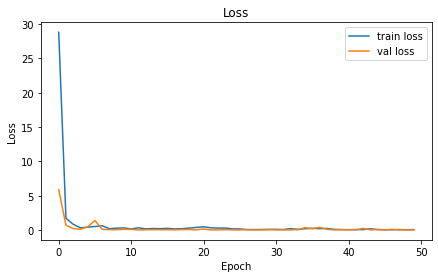

In [83]:
# loss
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
plt.plot(tvt2.history['loss'], label='train loss')
plt.plot(tvt2.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
fig.savefig('loss_model2')

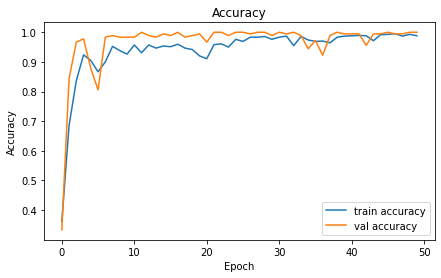

In [85]:
# accuracy
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
plt.plot(tvt2.history['accuracy'], label='train accuracy')
plt.plot(tvt2.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
fig.savefig('acc_model2')

**3. Model 3**

In [87]:
# model
weight_decay = 1e-5

def TVT_3():
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, 3, padding = 'same', strides = 1, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay), input_shape=(224,224, 3)))
    model.add(BatchNormalization())
    model.add(tfa.layers.InstanceNormalization())
    model.add(Activation('relu')) 
    model.add(Conv2D(32, 3, padding = 'same', strides = 1, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
    model.add(BatchNormalization())
    model.add(tfa.layers.InstanceNormalization())
    model.add(Activation('relu')) 
    model.add(Conv2D(32, 3, padding = 'same', strides = 1, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
    model.add(BatchNormalization())
    model.add(tfa.layers.InstanceNormalization())
    model.add(Activation('relu'))     
    model.add(MaxPooling2D()) 

    # Block 2
    model.add(Conv2D(64, 3, padding = 'same', strides = 1, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
    model.add(BatchNormalization())
    model.add(tfa.layers.InstanceNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, padding = 'same', strides = 1, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
    model.add(BatchNormalization())
    model.add(tfa.layers.InstanceNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, padding = 'same', strides = 1, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
    model.add(BatchNormalization())
    model.add(tfa.layers.InstanceNormalization())
    model.add(Activation('relu'))    
    model.add(MaxPooling2D())  
     
    # FCLs
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))

    return model

model3 = TVT_3()
model3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_44 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
instance_normalization_44 (I (None, 224, 224, 32)      64        
_________________________________________________________________
activation_44 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_45 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
instance_normalization_45 (I (None, 224, 224, 32)    

In [88]:
train_path = '/content/gdrive/MyDrive/Journal_paper/Database/train'
valid_path = '/content/gdrive/MyDrive/Journal_paper/Database/valid'
test_path = '/content/gdrive/MyDrive/Journal_paper/Database/test'

In [89]:
# tell the model what cost and optimization method to use
model3.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [90]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [91]:
# training
batch_size = 32
epochs = 50
steps = len(training_set) // batch_size

boundaries = [steps*15, steps*30]
values = [0.0001, 0.00005, 0.00001]
schedules = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
opt_adam  = keras.optimizers.Adam(learning_rate=schedules)

In [92]:
# fit the model
tvt3 = model3.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/50
27/27 [==============================] - 23s 722ms/step - loss: 48.3850 - accuracy: 0.3243 - val_loss: 9.9537 - val_accuracy: 0.3333
Epoch 2/50
27/27 [==============================] - 19s 698ms/step - loss: 7.1764 - accuracy: 0.3156 - val_loss: 4.0301 - val_accuracy: 0.3333
Epoch 3/50
27/27 [==============================] - 19s 696ms/step - loss: 2.8662 - accuracy: 0.3304 - val_loss: 0.8894 - val_accuracy: 0.5333
Epoch 4/50
27/27 [==============================] - 19s 694ms/step - loss: 1.1164 - accuracy: 0.5791 - val_loss: 0.3417 - val_accuracy: 0.8833
Epoch 5/50
27/27 [==============================] - 19s 698ms/step - loss: 0.6083 - accuracy: 0.8113 - val_loss: 0.2142 - val_accuracy: 0.9500
Epoch 6/50
27/27 [==============================] - 19s 697ms/step - loss: 0.3286 - accuracy: 0.9181 - val_loss: 0.2809 - val_accuracy: 0.9167
Epoch 7/50
27/27 [==============================] - 19s 696ms/step - loss: 0.4751 - accuracy: 0.8723 - val_loss: 0.1692 - val_accuracy: 0.966

In [93]:
# testing
score = model3.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.1601
Test accuracy: 0.9944


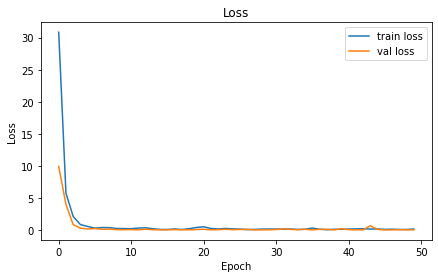

In [95]:
# loss
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
plt.plot(tvt3.history['loss'], label='train loss')
plt.plot(tvt3.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
fig.savefig('loss_model3')

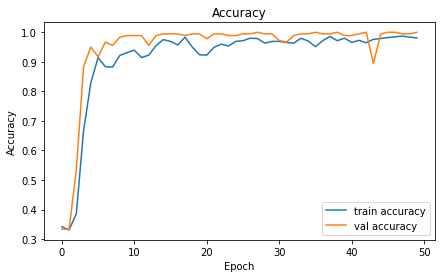

In [97]:
# accuracy
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
plt.plot(tvt3.history['accuracy'], label='train accuracy')
plt.plot(tvt3.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
fig.savefig('acc_model3')

**4. Model 4**

In [98]:
# model
weight_decay = 1e-5

def TVT_4():
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, 3, padding = 'same', strides = 1, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay), input_shape=(224,224, 3)))
    model.add(BatchNormalization())
    model.add(tfa.layers.InstanceNormalization())
    model.add(Activation('relu')) 
    model.add(Conv2D(32, 3, padding = 'same', strides = 1, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
    model.add(BatchNormalization())
    model.add(tfa.layers.InstanceNormalization())
    model.add(Activation('relu'))     
    model.add(MaxPooling2D()) 

    # Block 2
    model.add(Conv2D(64, 3, padding = 'same', strides = 1, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
    model.add(BatchNormalization())
    model.add(tfa.layers.InstanceNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, padding = 'same', strides = 1, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
    model.add(BatchNormalization())
    model.add(tfa.layers.InstanceNormalization())
    model.add(Activation('relu'))    
    model.add(MaxPooling2D())  

    # Block 3
    model.add(Conv2D(128, 3, padding = 'same', strides = 1, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
    model.add(BatchNormalization())
    model.add(tfa.layers.InstanceNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3, padding = 'same', strides = 1, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
    model.add(BatchNormalization())
    model.add(tfa.layers.InstanceNormalization())
    model.add(Activation('relu'))    
    model.add(MaxPooling2D())  
     
    # FCLs
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))

    return model

model4 = TVT_4()
model4.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_50 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
instance_normalization_50 (I (None, 224, 224, 32)      64        
_________________________________________________________________
activation_50 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_51 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
instance_normalization_51 (I (None, 224, 224, 32)    

In [102]:
train_path = '/content/gdrive/MyDrive/Journal_paper/Database/train'
valid_path = '/content/gdrive/MyDrive/Journal_paper/Database/valid'
test_path = '/content/gdrive/MyDrive/Journal_paper/Database/test'

In [103]:
# tell the model what cost and optimization method to use
model4.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [104]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [105]:
# training
batch_size = 32
epochs = 50
steps = len(training_set) // batch_size

boundaries = [steps*15, steps*30]
values = [0.0001, 0.00005, 0.00001]
schedules = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
opt_adam  = keras.optimizers.Adam(learning_rate=schedules)

In [106]:
# fit the model
tvt4 = model4.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/50
27/27 [==============================] - 21s 656ms/step - loss: 30.5277 - accuracy: 0.3695 - val_loss: 3.5762 - val_accuracy: 0.4778
Epoch 2/50
27/27 [==============================] - 18s 639ms/step - loss: 3.3085 - accuracy: 0.3611 - val_loss: 1.4879 - val_accuracy: 0.4278
Epoch 3/50
27/27 [==============================] - 17s 626ms/step - loss: 1.5116 - accuracy: 0.4350 - val_loss: 0.6086 - val_accuracy: 0.7722
Epoch 4/50
27/27 [==============================] - 17s 635ms/step - loss: 0.8759 - accuracy: 0.7223 - val_loss: 0.6171 - val_accuracy: 0.8611
Epoch 5/50
27/27 [==============================] - 17s 657ms/step - loss: 0.5475 - accuracy: 0.8658 - val_loss: 0.2586 - val_accuracy: 0.9611
Epoch 6/50
27/27 [==============================] - 18s 639ms/step - loss: 0.3202 - accuracy: 0.9321 - val_loss: 0.2524 - val_accuracy: 0.9667
Epoch 7/50
27/27 [==============================] - 18s 638ms/step - loss: 0.3326 - accuracy: 0.9238 - val_loss: 0.2542 - val_accuracy: 0.966

In [107]:
# testing
score = model4.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.1289
Test accuracy: 1.0000


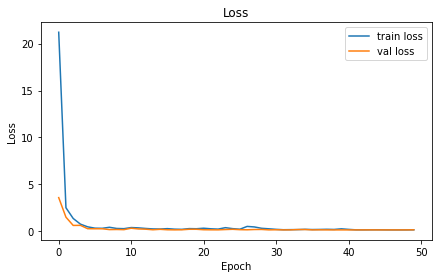

In [109]:
# loss
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
plt.plot(tvt4.history['loss'], label='train loss')
plt.plot(tvt4.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
fig.savefig('loss_model4')

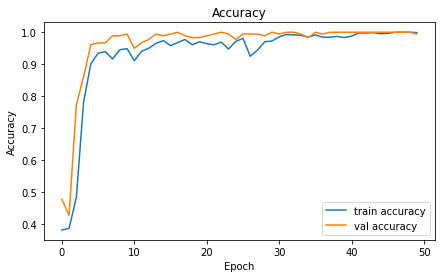

In [111]:
# accuracy
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
plt.plot(tvt4.history['accuracy'], label='train accuracy')
plt.plot(tvt4.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
fig.savefig('acc_model4')